In [1]:
%matplotlib inline
# Magic + imports likely common across all notebooks
%load_ext autoreload
%autoreload 2
%matplotlib inline
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')
# Set reference for util modules
import sys
sys.path.append('/home/jovyan/odc-hub/')

# supress warnings
import warnings
warnings.filterwarnings('ignore')

from utils_sac.createindices import NDVI, NDWI, NDBI
from utils_dcal.data_cube_utilities.dc_mosaic import create_median_mosaic, ls8_unpack_qa
from utils_dcal.data_cube_utilities.dc_mosaic import create_mosaic, ls8_unpack_qa
import numpy as np
import datacube 
from datetime import datetime
from utils_dcal.data_cube_utilities.dc_utilities import write_png_from_xr, write_geotiff_from_xr
from utils_dcal.data_cube_utilities.dc_display_map import display_map

# NDVI  
<br>  
  
> **NDVI(Normalized Difference Vegetation Index**  
> A derived index that correlates well with the existance of vegetation.  

<br>

$$ NDVI =  \frac{(NIR - RED)}{(NIR + RED)}$$  

<br>

# NDWI  
  
> **NDWI Normalized Difference Water Index**  
> A derived index that correlates well with the existance of water.  
<br>

$$ NDWI =  \frac{GREEN - NIR}{GREEN + NIR}$$  
  
<br>

# NDBI  

> **NDWI Normalized Difference Build-Up Index**  
> A derived index that correlates well with the existance of urbanization.  
<br>

$$ NDBI =  \frac{(SWIR - NIR)}{(SWIR + NIR)}$$  
 
<br>  

# MOSAIC  
  
>**Recent-Pixel-First Mosaic**   
>A cloud free representation of satellite imagery. Works by masking out clouds from imagery, and using the most recent cloud-free pixels in an image.  

![](diagrams/urbanization/flat_mosaic.png)
  
<br>  

In [2]:


def mosaic(dataset):
    # The mask here is based on pixel_qa. It comes bundled in with most Landsat Products.
    clear_xarray  = ls8_unpack_qa(dataset.pixel_qa, "clear")  # Boolean Xarray indicating landcover
    water_xarray  = ls8_unpack_qa(dataset.pixel_qa, "water")  # Boolean Xarray indicating watercover
    
    cloud_free_boolean_mask = np.logical_or(clear_xarray, water_xarray)
    
    return create_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

<br>
  
> **Median Mosaic**  
>  A cloud free representation fo satellite imagery. Works by masking out clouds from imagery, and using the median valued cloud-free pixels in the time series  
  
<br>


![](diagrams/urbanization/median_comp.png)  
  
<br>

In [3]:

def median_mosaic(dataset):
    # The mask here is based on pixel_qa. It comes bundled in with most Landsat Products.
    clear_xarray  = ls8_unpack_qa(dataset.pixel_qa, "clear")  # Boolean Xarray indicating landcover
    water_xarray  = ls8_unpack_qa(dataset.pixel_qa, "water")  # Boolean Xarray indicating watercover
    
    cloud_free_boolean_mask = np.logical_or(clear_xarray, water_xarray)
    
    return create_median_mosaic(dataset, clean_mask = cloud_free_boolean_mask)

<br>  

# Loading Data

> **Data cube object**  
> A datacube object is your interface with data stored on your data cube system.  
<br>  

In [4]:
 
dc = datacube.Datacube(app = '3B_urban')  

<br>

> **Loading a Dataset**  
> Requires latitude-longitude bounds of an area, a time-range, list of desired measurements, platform and product names.

In [8]:
output_projection = "EPSG:32760"
resolution = (-30, 30)
platform = 'LANDSAT_4'
product = 'ls4_usgs_sr_scene'
platform_analy = 'LANDSAT_8'
product_analy = 'ls8_usgs_sr_scene'

In [9]:
from utils_sac.createAOI import create_lat_lon
#aoi_wkt = "POLYGON ((178.3652687072754 -18.166893514761473, 178.5051727294922 -18.166893514761473, 178.5051727294922 -18.094460132375914, 178.3652687072754 -18.094460132375914, 178.3652687072754 -18.166893514761473))"
aoi_wkt = "POLYGON((178.98101806642 -17.592544555664, 179.03903961183 -17.593231201171, 179.03903961183 -17.66258239746, 178.97998809815 -17.661209106445, 178.98101806642 -17.592544555664))"
lat, lon = create_lat_lon(aoi_wkt)
print("Lat:", lat, "\n"
      "Lon:", lon)

Lat: (-17.66258239746, -17.592544555664) 
Lon: (178.97998809815, 179.03903961183)


In [7]:
query = {
    'latitude' : lat,
    'longitude': lon,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product,
    'platform' : platform 
}

In [8]:
query_analy = {
    'latitude' : lat,
    'longitude': lon,
    'output_crs': output_projection,  
    'resolution': resolution,
    'product' : product_analy,
    'platform' : platform_analy 
}

In [9]:
## Loading in a region
start_date = datetime(2017,1,1)
end_date = datetime(2017,12,24)
date_range_base = (start_date,end_date)

desired_bands = ['red','green','nir','swir2', 'pixel_qa']  # needed by ndvi, ndwi, ndbi and cloud masking
desired_bands = desired_bands + ['blue'] # blue is needed for a true color visualization purposes

landsat_dataset_base = dc.load(
    group_by='solar_day',
    time = date_range_base,
    measurements = desired_bands,
    **query
)

print(landsat_dataset_base)

<xarray.Dataset>
Dimensions:   (time: 44, x: 213, y: 261)
Coordinates:
  * time      (time) datetime64[ns] 2017-01-07T22:06:49 ... 2017-12-18T22:00:38
  * y         (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    red       (time, y, x) int16 139 112 81 63 63 ... -9999 -9999 -9999 -9999
    green     (time, y, x) int16 193 170 143 219 380 ... -9999 -9999 -9999 -9999
    nir       (time, y, x) int16 167 135 113 93 90 ... -9999 -9999 -9999 -9999
    swir2     (time, y, x) int16 195 175 156 144 144 ... -9999 -9999 -9999 -9999
    pixel_qa  (time, y, x) uint16 324 324 324 324 324 324 324 ... 1 1 1 1 1 1 1
    blue      (time, y, x) int16 240 219 204 317 631 ... -9999 -9999 -9999 -9999
Attributes:
    crs:      EPSG:32760


In [10]:
start_date_analy = datetime(2013,1,1)
end_date_analy = datetime(2013,12,30)
date_range_analy = (start_date_analy,end_date_analy)

landsat_dataset_analysis = dc.load(
    group_by='solar_day',
    time = date_range_analy,
    measurements = desired_bands,
    **query_analy
)

In [11]:
print(landsat_dataset_analysis)

<xarray.Dataset>
Dimensions:   (time: 23, x: 213, y: 261)
Coordinates:
  * time      (time) datetime64[ns] 2013-04-27T22:02:12 ... 2013-12-23T22:01:54
  * y         (y) float64 8.054e+06 8.054e+06 8.054e+06 ... 8.046e+06 8.046e+06
  * x         (x) float64 7.1e+05 7.101e+05 7.101e+05 ... 7.164e+05 7.164e+05
Data variables:
    red       (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    green     (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    nir       (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    swir2     (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
    pixel_qa  (time, y, x) uint16 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1
    blue      (time, y, x) int16 -9999 -9999 -9999 -9999 ... -9999 -9999 -9999
Attributes:
    crs:      EPSG:32760


In [12]:
display_map(latitude = lat, longitude = lon)  

<br>  

# Displaying Data  
<br>  

>**A cloud free composite**  
Clouds get in the way of understanding the area. Cloud free composites draw from a history of acquisitions to generate a cloud free representation of your area  

<br>  

In [13]:
landsat_mosaic_base = median_mosaic(landsat_dataset_base)
landsat_mosaic_analy = median_mosaic(landsat_dataset_analysis)

<br>  
> **Saving your data**  
> A .tiff or png is a great way to represent true color mosaics. The image below is a saved .png representation of of a landsat mosaic.  

In [14]:
landsat_mosaic_base = landsat_mosaic_base.rename({"x":"latitude", "y":"longitude"})
cloud_Free_base = write_png_from_xr('cloud_free_mosaic_base.png', landsat_mosaic_base, ["red", "green", "blue"], scale = [(0,2000),(0,2000),(0,2000)], crs="EPSG:32760")
write_geotiff_from_xr('cloud_free_mosaic_base.tiff', landsat_mosaic_base, ["red", "green", "blue"], crs=output_projection)


In [1]:
landsat_mosaic_analy = landsat_mosaic_analy.rename({"x":"latitude", "y":"longitude"})
cloud_Free_analy = write_png_from_xr('cloud_free_mosaic_analy.png', landsat_mosaic_analy, ["red", "green", "blue"], scale = [(0,2000),(0,2000),(0,2000)], crs="EPSG:32760")
write_geotiff_from_xr('cloud_free_mosaic_analy.tiff', landsat_mosaic_analy, ["red", "green", "blue"], crs=output_projection)


NameError: name 'landsat_mosaic_analy' is not defined

<br>  

![](diagrams/urbanization/cloud_free_mosaic.png)  
  
<br>  

# Urbanization Analysis  

> **NDWI, NDVI, NDBI**  
You will very rarely have urban classification and water classifications apply to the same pixel. For urban analysis, it may make sense to compute not just urban classes, but classes that are unlikely to co-occur with urbanization. 
  
<br>

In [16]:
ndbi_base = NDBI(landsat_mosaic_base)  # Urbanization
ndvi_base = NDVI(landsat_mosaic_base)  # Dense Vegetation
ndwi_base = NDWI(landsat_mosaic_base)  # High Concentrations of Water

In [17]:
ndbi_analy = NDBI(landsat_mosaic_analy)  # Urbanization
ndvi_analy = NDVI(landsat_mosaic_analy)  # Dense Vegetation
ndwi_analy = NDWI(landsat_mosaic_analy)  # High Concentrations of Water

>**Plot Values**  
> xarray data-arrays have built in plotting functions you can use to validate trends or differences in your data.  
<br>
  

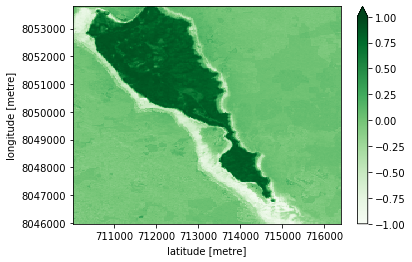

In [18]:
(ndvi_base).plot(cmap = "Greens", vmin = -1, vmax = 1)

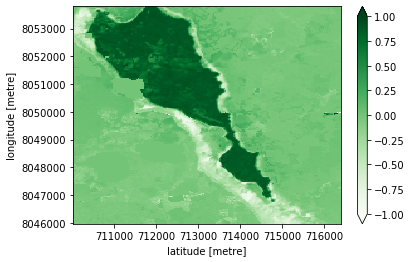

In [19]:
(ndvi_analy).plot(cmap = "Greens", vmin = -1, vmax = 1)

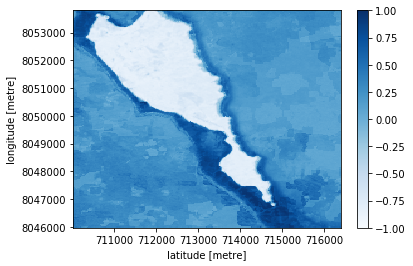

In [20]:
(ndwi_base).plot(cmap = "Blues", vmin = -1, vmax = 1)

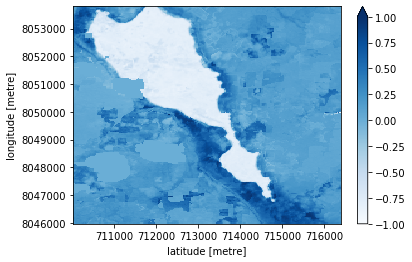

In [21]:
(ndwi_analy).plot(cmap = "Blues", vmin = -1, vmax = 1)

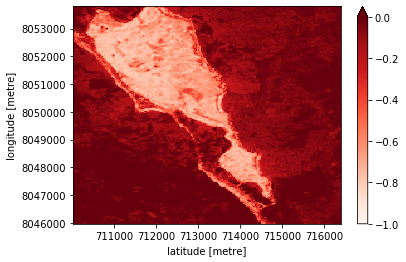

In [22]:
(ndbi_base).plot(cmap = "Reds", vmin = -1, vmax = 0)

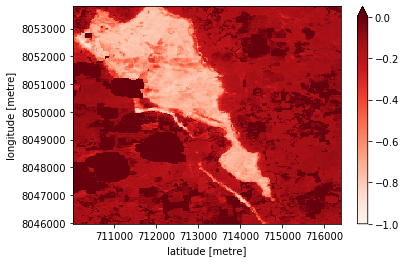

In [23]:
(ndbi_analy).plot(cmap = "Reds", vmin = -1, vmax = 0)

> **Convert To a Dataset**  
It's good practice to accurately name your datasets and data-arrays. If you'd like to merge data-arrays into a larger datasets, you should convert data-arrays to datasets

In [24]:
ds_ndvi_base = ndvi_base.to_dataset(name = "NDVI")
ds_ndwi_base = ndwi_base.to_dataset(name=  "NDWI")
ds_ndbi_base = ndbi_base.to_dataset(name = "NDBI")

In [25]:
ds_ndvi_analy = ndvi_analy.to_dataset(name = "NDVI")
ds_ndwi_analy = ndwi_analy.to_dataset(name = "NDWI")
ds_ndbi_analy = ndbi_analy.to_dataset(name = "NDBI")

> **Merge into one large Dataset**  
> If your data-arrays share the same set of coordinates, or if you feel that you'll be using these values together in the future,  you should consider merging them into a dataset

In [26]:
urbanization_dataset_base = ds_ndvi_analy.merge(ds_ndwi_base).merge(ds_ndbi_base)
urbanization_dataset_analy = ds_ndvi_analy.merge(ds_ndwi_analy).merge(ds_ndbi_analy)

In [27]:
#####edited up to here

>**Checking your Merge**  
>The string readout of your new dataset should give you a good idea about how the `.merge` went.  
<br>

<br>  
<br>  

>**Building a False Color Composite**  
> If you have three lowly correlated measurements, place each measurement on its own Red, Green, Blue channel and visualize it. 

In [28]:
write_png_from_xr('false_color_base.png', urbanization_dataset_base, ["NDBI", "NDVI", "NDWI"], scale = [(-1,1),(0,1),(0,1)])
write_geotiff_from_xr('false_color_base.tiff', urbanization_dataset_base, ["NDBI", "NDVI", "NDWI"], crs=output_projection)

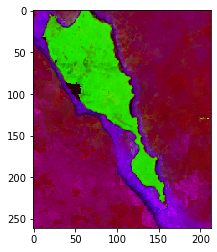

In [29]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
image_base = mpimg.imread("false_color_base.png")
plt.imshow(image_base)
plt.show()

In [30]:
write_png_from_xr('false_color_analy.png', urbanization_dataset_analy, ["NDBI", "NDVI", "NDWI"], scale = [(-1,1),(0,1),(0,1)])
write_geotiff_from_xr('false_color_analy.tiff', urbanization_dataset_analy, ["NDBI", "NDVI", "NDWI"], crs=output_projection)

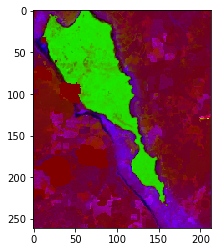

In [31]:
image_base = mpimg.imread("false_color_analy.png")
plt.imshow(image_base)
plt.show()

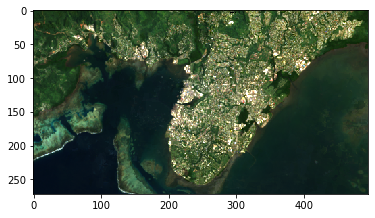

In [32]:
cloud_free_image = mpimg.imread("cloud_free_mosaic.png")
plt.imshow(cloud_free_image)
plt.show()

![](diagrams/urbanization/false_color.png)

>**Analyze The False Color Image**  

> Values that adhere strongly to individual classes adhere to their own color channel. In this example, NDVI adheres to green, NDWI adheres to blue, and NDBI seems to adhere to red  

> **Validate urbanization using other imagery**  
> Double check results using high-resolution imagery.  Compare to the false color mosaic
<br>

In [33]:
display_map(latitude = lat ,longitude = lon)  

## set thresholds for ndvi, ndwi and ndbi

In [34]:
#ndwi
ndwi_min = -1
ndwi_max = -0.1
#ndvi
ndvi_min = -1
ndvi_max = 0.5
#ndbi
ndbi_min = -0.9
ndbi_max = 0


In [35]:
ndwi_mask_base = np.logical_and(ndwi_base > ndwi_min, ndwi_base < ndwi_max) 
ndvi_mask_base = np.logical_and(ndvi_base > ndvi_min, ndvi_base < ndvi_max)
ndbi_mask_base = np.logical_and(ndbi_base > ndbi_min, ndbi_base < ndbi_max)

In [36]:
ndwi_mask_analy = np.logical_and(ndwi_analy > ndwi_min, ndwi_analy < ndwi_max) 
ndvi_mask_analy = np.logical_and(ndvi_analy > ndvi_min, ndvi_analy < ndvi_max)
ndbi_mask_analy = np.logical_and(ndbi_analy > ndbi_min, ndbi_analy < ndbi_max)

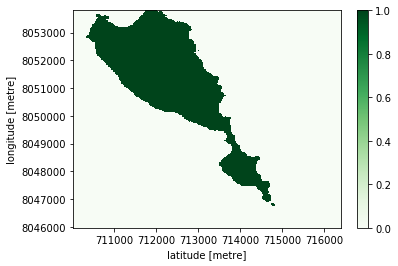

In [37]:
ndwi_mask_base.plot(cmap = "Greens")

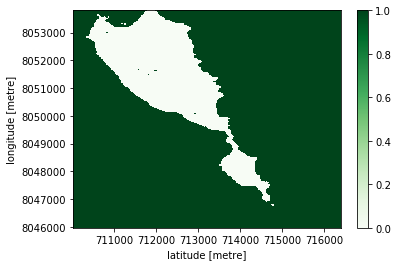

In [38]:
ndvi_mask_base.plot(cmap = "Greens")

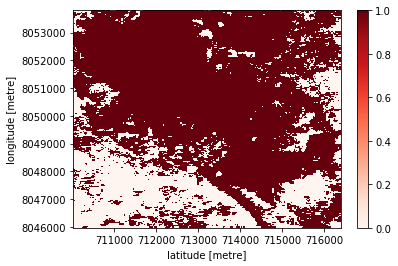

In [39]:
ndbi_mask_base.plot(cmap = "Reds")

In [40]:
#create a mask here 

In [41]:
from datacube.storage import masking
mask_ndwi_base = masking.mask_invalid_data(ndwi_mask_base)
mask_ndvi_base = masking.mask_invalid_data(ndvi_mask_base)
mask_ndbi_base = masking.mask_invalid_data(ndbi_mask_base)

In [42]:
mask_ndwi_analy = masking.mask_invalid_data(ndwi_mask_analy)
mask_ndvi_analy = masking.mask_invalid_data(ndvi_mask_analy)
mask_ndbi_analy = masking.mask_invalid_data(ndbi_mask_analy)

In [43]:
ndbi_test_base = ndbi_base.where(mask_ndwi_base)
ndbi_test_base = ndbi_test_base.where(mask_ndvi_base)
ndbi_test_base = ndbi_test_base.where(mask_ndbi_base)

In [44]:
ndbi_test_analy = ndbi_analy.where(mask_ndwi_analy)
ndbi_test_analy = ndbi_test_analy.where(mask_ndvi_analy)
ndbi_test_analy = ndbi_test_analy.where(mask_ndbi_analy)

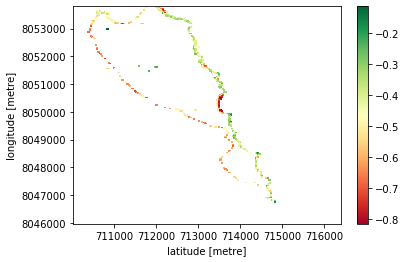

In [45]:
ndbi_test_base.plot(cmap = "RdYlGn")

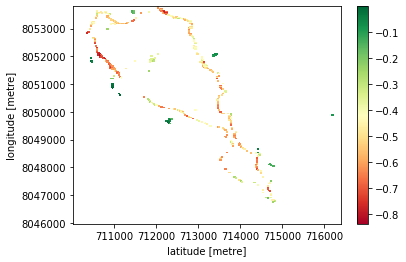

In [46]:
ndbi_test_analy.plot(cmap = "RdYlGn")

In [47]:
#####experimenting with ndvi - ndbi
#test2 = ndvi_base - ndbi_base
test2 = np.subtract(ndbi_base, ndvi_base)
#RdYlGn.set_bad('black',1.)
test2.plot(cmap = RdYlGn)
test3 = test2.where(mask_ndwi_base)
test3 = test3.where(mask_ndvi_base)

NameError: name 'RdYlGn' is not defined

In [ ]:
test3.plot(cmap = RdYlGn)

In [ ]:
cloud_free_image = mpimg.imread("cloud_free_mosaic.png")
plt.imshow(cloud_free_image)
plt.show()

In [ ]:
test = np.subtract(ndbi_test_analy, ndbi_test_base)

In [ ]:
test.plot()

In [ ]:
def aspect_ratio_helper(ds, fixed_width = 12):
        y,x = ds.values.shape
        width = fixed_width
        height = y * (fixed_width / x)
        return (width, height)

In [ ]:
from matplotlib.cm import RdYlGn, Greens
RdYlGn.set_bad('black',1.)
Greens.set_bad('black',1.)

In [ ]:
plt.figure(figsize = aspect_ratio_helper(test)) 
test.plot(cmap = RdYlGn)

In [ ]:
# CHANGE HERE >>>>>>>>>>>>>>>>>>>>

# Select an Anomaly Threshold Range to filter the results from the previous image
# Be sure to put the smallest value in the "minimum_change" location (be careful of negative values)

# Losses are typically in these ranges for deforestation
# NDVI: -0.2 to -0.7
# EVI: -0.5 to -1.75
# Fractional Cover PV: -20 to -70

minimum_change = -0.3
maximum_change = -1

In [ ]:
# Create a threshold plot using the MIN and MAX range defined above

from matplotlib.ticker import FuncFormatter

def threshold_plot(da, min_threshold, max_threshold, mask = None, width = 10, *args, **kwargs): 
    color_in    = np.array([255,0,0])
    color_out   = np.array([0,0,0])
    color_cloud = np.array([255,255,255])
    
    array = np.zeros((*da.values.shape, 3)).astype(np.int16)
    
    inside  = np.logical_and(da.values > min_threshold, da.values < max_threshold)
    outside = np.invert(inside)
    masked  = np.zeros(da.values.shape).astype(bool) if mask is None else mask
    
    array[inside] =  color_in
    array[outside] = color_out
    array[masked] =  color_cloud

    def figure_ratio(ds, fixed_width = 10):
        width = fixed_width
        height = len(ds.latitude) * (fixed_width / len(ds.longitude))
        return (width, height)


    fig, ax = plt.subplots(figsize = figure_ratio(da,fixed_width = width))
    
    lat_formatter = FuncFormatter(lambda y_val, tick_pos: "{0:.3f}".format(da.latitude.values[tick_pos] ))
    lon_formatter = FuncFormatter(lambda x_val, tick_pos: "{0:.3f}".format(da.longitude.values[tick_pos]))

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    
    plt.title("Threshold: {} < x < {}".format(min_threshold, max_threshold))
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.imshow(array, *args, **kwargs)
    plt.show()

In [ ]:
no_data_mask = np.logical_or(np.isnan(ndbi_test_analy.values), np.isnan(ndbi_test_base.values)) 

In [ ]:
threshold_plot(test, minimum_change, maximum_change, mask = no_data_mask)

In [ ]:
min_change = 0.3
max_change = 1
threshold_plot(test, min_change, max_change, mask = no_data_mask )